In [1]:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import optuna

import lightgbm 
import xgboost
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore") 

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test  = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

train.drop(columns=["id"], inplace=True)
test.drop(columns=["id"], inplace=True)

In [3]:
RMSE = lambda y_true, y_pred: np.sqrt(np.mean((y_true - y_pred)**2))

## Splitted dataset
X = train.copy()
y = X.pop("BeatsPerMinute")

In [4]:
def cross_validate(model, X, y, n_splits=10, scaler=None, model_name=None):
    ## Converts to numpy arrays
    X_npy = np.asarray(X)
    y_npy = np.asarray(y)
        
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=3126)
    y_oof = np.zeros_like(y_npy, dtype=float)
    rmse  = []
    history = {}
        
    for train_idx,val_idx in kfold.split(X_npy):
        ## Splits data
        X_train, y_train = X_npy[train_idx], y_npy[train_idx]
        X_val,   y_val   = X_npy[val_idx],   y_npy[val_idx]

        ## Scales data if applicable
        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_val   = scaler.transform(X_val)
        
        ## Fits cloned model
        cloned_model = clone(model)
        if model_name=="lgbm":
            cloned_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse', 
                callbacks=[lightgbm.early_stopping(min_delta=.01, stopping_rounds=75, verbose=False)]
            )
        elif model_name=="xgb":
            cloned_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=75,
                verbose=False
            )
        else:
            cloned_model.fit(X_train, y_train)
            
        ## Gets OOF prediction and stores it
        y_pred = cloned_model.predict(X_val)
        y_oof[val_idx] = y_pred
        ## Stores metric
        rmse.append(RMSE(y_val, y_pred))

    history["y_oof"] = y_oof
    history["rmse"]  = np.array(rmse)
    return history

# Evaluating LGBMRegressor

In [5]:
# def objective_lgbm(trial):
#     ## Parameter to tune
#     n_estimators     = trial.suggest_int("n_estimators", 100, 5000)
#     max_depth        = trial.suggest_int("max_depth", 4, 10)
#     num_leaves       = trial.suggest_int("num_leaves", 2**3, 2**max_depth)
#     learning_rate    = trial.suggest_float("learning_rate", .003, 1.5, log=True)
#     reg_alpha        = trial.suggest_float("reg_alpha", .001, 1.5, log=True)
#     reg_lambda       = trial.suggest_float("reg_lambda", .001, 2.0, log=True)
#     colsample_bytree = trial.suggest_float("colsample_bytree", .5, 1.0)
#     importance_type  = trial.suggest_categorical("importance_type", ["split", "gain"])

#     ## Initialize parameters
#     params = {
#         "n_estimators":n_estimators, 
#         "max_depth":max_depth,
#         "num_leaves":num_leaves,
#         "learning_rate":learning_rate,
#         "reg_alpha":reg_alpha,
#         "reg_lambda":reg_lambda,
#         "colsample_bytree":colsample_bytree,
#         "importance_type":importance_type
#     }
#     params["n_jobs"] = -1
#     params["random_state"] = 3126
#     params["verbose"] = -1
#     params["metric"] = "rmse"
    
#     ## Cross validates model
#     lgbm = LGBMRegressor(**params)
#     history = cross_validate(lgbm, X, y, n_splits=10, model_name="lgbm")
#     return history["rmse"].mean()

# sampler = optuna.samplers.TPESampler(seed=3126) 
# study = optuna.create_study(direction="minimize", sampler=sampler)
# study.optimize(objective_lgbm, n_trials=100)


# print("Best LGBM trial:")
# trial = study.best_trial
# print("RMSE:", round(trial.value, 5))
# print("Params:", trial.params)

# Best LGBM trial:
# RMSE: 26.46037

In [6]:
lgbm_params = {
 'n_estimators': 1746,
 'max_depth': 6,
 'num_leaves': 13,
 'learning_rate': 1.0542803584512304,
 'reg_alpha': 0.03412037417555589,
 'reg_lambda': 0.0022429088241493074,
 'colsample_bytree': 0.9821769652484116,
 'importance_type': 'split'
}
lgbm_params["n_jobs"]  = -1
lgbm_params["random_state"] = 3126
lgbm_params["verbose"] = -1
lgbm_params["metric"]  = "rmse"

lgbm = LGBMRegressor(**lgbm_params)
history_lgbm = cross_validate(lgbm, X, y, n_splits=10, model_name="lgbm")

In [7]:
print(f"LGBM RMSE: {history_lgbm['rmse'].mean():.5f} ± {history_lgbm['rmse'].std():.5f}")

LGBM RMSE: 26.46037 ± 0.08332


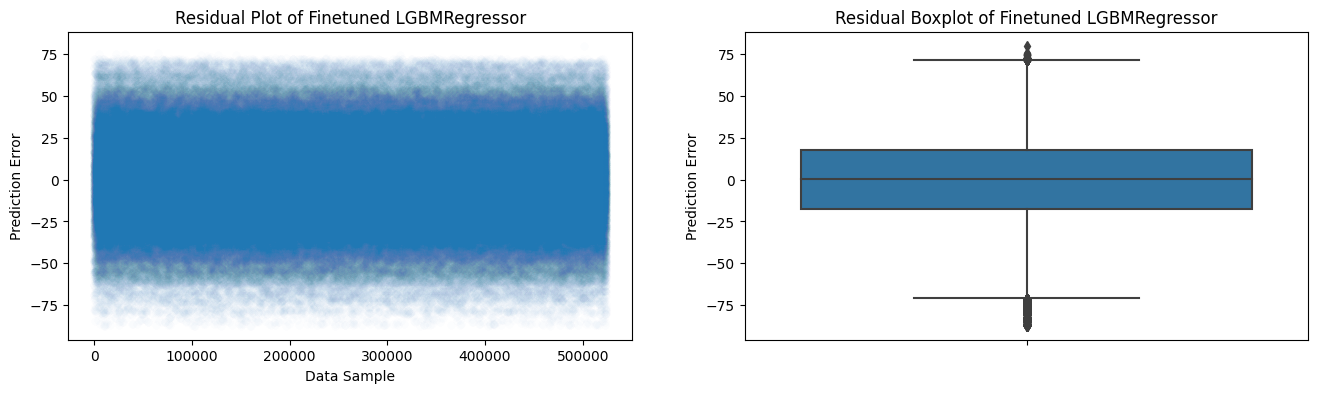

In [8]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.scatterplot(x=np.arange(1, len(X)+1), y=history_lgbm["y_oof"]-y, alpha=.01)
plt.xlabel("Data Sample")
plt.ylabel("Prediction Error")
plt.title("Residual Plot of Finetuned LGBMRegressor")


plt.subplot(122)
sea.boxplot(y=history_lgbm["y_oof"]-y)
plt.xlabel("")
plt.ylabel("Prediction Error")
plt.title("Residual Boxplot of Finetuned LGBMRegressor")
plt.show()

# Evaluating XGBRegressor

In [9]:
# def objective_xgb(trial):
#     ## Parameter to tune
#     n_estimators     = trial.suggest_int("n_estimators", 100, 2000)
#     max_depth        = trial.suggest_int("max_depth", 4, 10)
#     max_leaves       = trial.suggest_int("max_leaves", 2**3, 2**max_depth)
#     learning_rate    = trial.suggest_float("learning_rate", .0075, 2.0, log=True)
#     reg_alpha        = trial.suggest_float("reg_alpha", .001, 1.5, log=True)
#     reg_lambda       = trial.suggest_float("reg_lambda", .001, 2.0, log=True)
#     gamma            = trial.suggest_float("gamma", 0.001, 5.0, log=True)
#     colsample_bytree = trial.suggest_float("colsample_bytree", .5, 1.0)
#     subsample        = trial.suggest_float("subsample", 0.5, 1.0)
#     min_child_weight = trial.suggest_int("min_child_weight", 1, 20)
    
#     ## Initialize parameters
#     params = {
#         "n_estimators":n_estimators, 
#         "max_depth":max_depth,
#         "max_leaves":max_leaves,
#         "learning_rate":learning_rate,
#         "reg_alpha":reg_alpha,
#         "reg_lambda":reg_lambda,
#         "gamma":gamma,
#         "colsample_bytree":colsample_bytree,
#         "subsample":subsample,
#         "min_child_weight":min_child_weight
#     }
#     params["n_jobs"] = -1
#     params["random_state"] = 3126
#     params["verbosity"] = 0
#     params["eval_metric"] = "rmse"
    
#     ## Cross validates model
#     xgb = XGBRegressor(**params)
#     history = cross_validate(xgb, X, y, n_splits=10, model_name="xgb")
#     return history["rmse"].mean()

# sampler = optuna.samplers.TPESampler(seed=3126) 
# study = optuna.create_study(direction="minimize", sampler=sampler)
# study.optimize(objective_xgb, n_trials=100)

# print("Best XGB trial:")
# trial = study.best_trial
# print("RMSE:", round(trial.value, 5))
# print("Params:", trial.params)

# Best XGB trial:
# RMSE: 26.4597

In [10]:
xgb_params = {
 'n_estimators': 1399,
 'max_depth': 6,
 'max_leaves': 38,
 'learning_rate': 0.01855962903886693,
 'reg_alpha': 0.001523578381342185,
 'reg_lambda': 0.006131662564182482,
 'gamma': 0.001357580025577093,
 'colsample_bytree': 0.9252152040029055,
 'subsample': 0.632595139006321,
 'min_child_weight': 14
}
xgb_params["n_jobs"]       = -1
xgb_params["random_state"] = 3126
xgb_params["verbosity"]    = 0
xgb_params["eval_metric"]  = "rmse"

xgb = XGBRegressor(**xgb_params)
history_xgb = cross_validate(xgb, X, y, n_splits=10, model_name="xgb")

In [11]:
print(f"XGB RMSE: {history_xgb['rmse'].mean():.5f} ± {history_xgb['rmse'].std():.5f}")

XGB RMSE: 26.45970 ± 0.08258


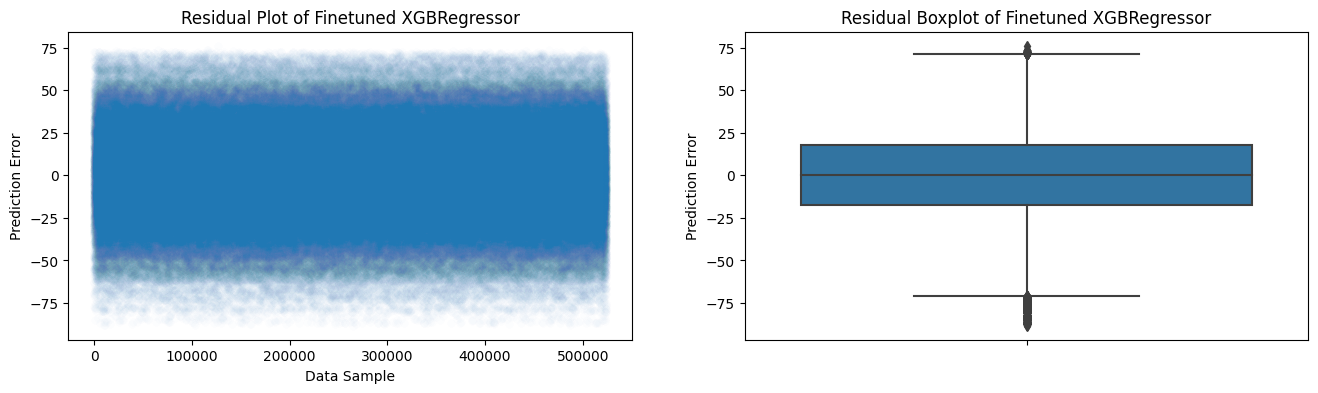

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.scatterplot(x=np.arange(1, len(X)+1), y=history_xgb["y_oof"]-y, alpha=.01)
plt.xlabel("Data Sample")
plt.ylabel("Prediction Error")
plt.title("Residual Plot of Finetuned XGBRegressor")


plt.subplot(122)
sea.boxplot(y=history_xgb["y_oof"]-y)
plt.xlabel("")
plt.ylabel("Prediction Error")
plt.title("Residual Boxplot of Finetuned XGBRegressor")
plt.show()

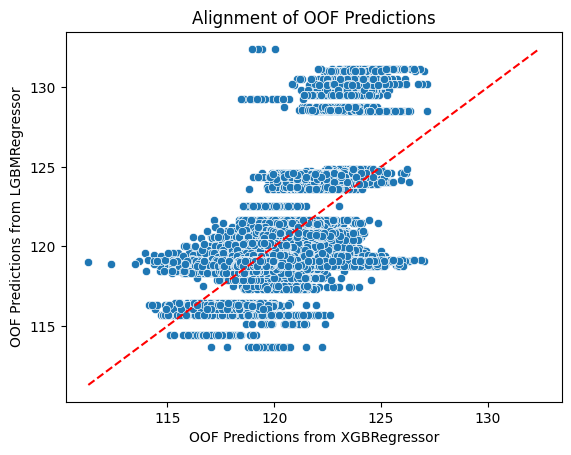

In [13]:
sea.scatterplot(x=history_xgb["y_oof"], y=history_lgbm["y_oof"])

# Draw y = x line
min_val = min(history_xgb["y_oof"].min(), history_lgbm["y_oof"].min())
max_val = max(history_xgb["y_oof"].max(), history_lgbm["y_oof"].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.xlabel("OOF Predictions from XGBRegressor")
plt.ylabel("OOF Predictions from LGBMRegressor")
plt.title("Alignment of OOF Predictions")
plt.show()

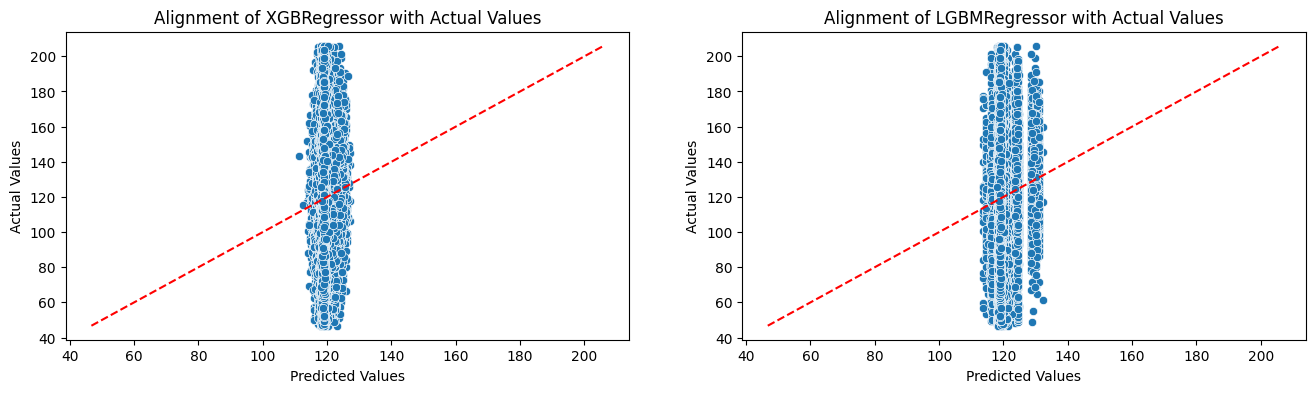

In [14]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.scatterplot(x=history_xgb["y_oof"], y=y)
min_val = min(history_xgb["y_oof"].min(), y.min())
max_val = max(history_xgb["y_oof"].max(), y.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Alignment of XGBRegressor with Actual Values")


plt.subplot(122)
sea.scatterplot(x=history_lgbm["y_oof"], y=y)
min_val = min(history_lgbm["y_oof"].min(), y.min())
max_val = max(history_lgbm["y_oof"].max(), y.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Alignment of LGBMRegressor with Actual Values")

plt.show()

# Ensembling with Ridge

In [15]:
oof_data = pd.DataFrame(
    {"lgbm":history_lgbm["y_oof"], 
     "xgb" :history_xgb["y_oof"]}
)

In [16]:
# def objective_xgb(trial):
#     alpha = trial.suggest_float("alpha", .01, 10, log=True)
    
#     ## Cross validates model
#     ridge = Ridge(alpha=alpha, random_state=3126)
#     history = cross_validate(ridge, oof_data, y, n_splits=10)
#     return history["rmse"].mean()

# sampler = optuna.samplers.TPESampler(seed=3126) 
# study = optuna.create_study(direction="minimize", sampler=sampler)
# study.optimize(objective_xgb, n_trials=100)

# print("Best Ridge trial:")
# trial = study.best_trial
# print("RMSE:", round(trial.value, 5))
# print("Params:", trial.params)

# Best Ridge trial:
# RMSE: 26.45837

In [17]:
lgbm_params = {
 'n_estimators': 1746,
 'max_depth': 6,
 'num_leaves': 13,
 'learning_rate': 1.0542803584512304,
 'reg_alpha': 0.03412037417555589,
 'reg_lambda': 0.0022429088241493074,
 'colsample_bytree': 0.9821769652484116,
 'importance_type': 'split'
}
lgbm_params["n_jobs"]  = -1
lgbm_params["random_state"] = 3126
lgbm_params["verbose"] = -1
lgbm_params["metric"]  = "rmse"

lgbm = LGBMRegressor(**lgbm_params).fit(X, y)

In [18]:
xgb_params = {
 'n_estimators': 1399,
 'max_depth': 6,
 'max_leaves': 38,
 'learning_rate': 0.01855962903886693,
 'reg_alpha': 0.001523578381342185,
 'reg_lambda': 0.006131662564182482,
 'gamma': 0.001357580025577093,
 'colsample_bytree': 0.9252152040029055,
 'subsample': 0.632595139006321,
 'min_child_weight': 14
}
xgb_params["n_jobs"]       = -1
xgb_params["random_state"] = 3126
xgb_params["verbosity"]    = 0
xgb_params["eval_metric"]  = "rmse"

xgb = XGBRegressor(**xgb_params).fit(X, y)

In [19]:
alpha = 9.986169132497814
ridge = Ridge(alpha=alpha, random_state=3126)
ridge.fit(oof_data, y)

Ridge(alpha=9.986169132497814, random_state=3126)

In [20]:
lgbm_pred = lgbm.predict(test)
xgb_pred  = xgb.predict(test)

test_ensemble = pd.DataFrame(
    {"lgbm":lgbm_pred,
     "xgb":xgb_pred}
)

y_pred = ridge.predict(test_ensemble)

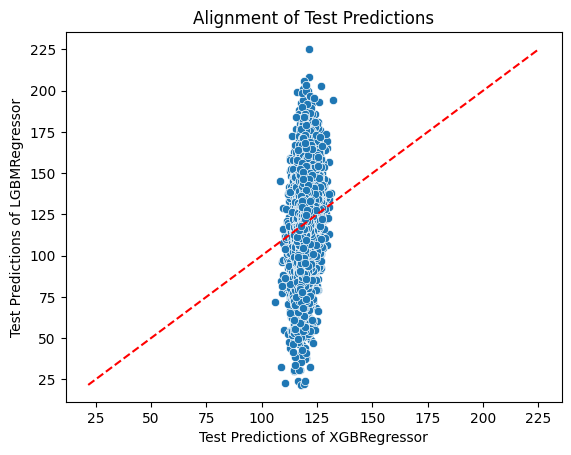

In [21]:
sea.scatterplot(x=xgb_pred, y=lgbm_pred)

# Draw y = x line
min_val = min(xgb_pred.min(), lgbm_pred.min())
max_val = max(xgb_pred.max(), lgbm_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.xlabel("Test Predictions of XGBRegressor")
plt.ylabel("Test Predictions of LGBMRegressor")
plt.title("Alignment of Test Predictions")
plt.show()

In [22]:
sample_submission["BeatsPerMinute"] = y_pred
sample_submission.to_csv("submission.csv", index=False)

In [23]:
import joblib

In [24]:
joblib.dump(lgbm, "naive_tuned_lgbm.joblib")
joblib.dump(xgb, "naive_tuned_xgb.joblib")
joblib.dump(ridge, "naive_tuned_ridge.joblib")

['naive_tuned_ridge.joblib']